# Show and Tell v23
## Milestone 2
## Rishi Ghia, Santnam Bakshi, Purvansh Jain

In this notebook, are present the following sections:
1. Dataset Initialization
2. Data Loader Initialization
3. Caption Preprocessing
4. Evaluation Script
5. Simple Baseline

(Strong Baseline)

7. CNN
8. Image Feature Extraction
9. LSTM
10. Training
11. Inference


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from collections import Counter
from itertools import chain
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f'Using device: {device}')

Using device: cuda


# Dataset Class

Below we have defined the dataset class, which shall be used throughout the project to access the images, and their respective captions. 

In [3]:
class CustomCocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        # Create a mapping from image IDs to filenames
        self.id_to_filename = {item['id']: item['file_name'] for item in self.data['images']}

        # Create a mapping from image IDs to captions
        # Note that there might be multiple captions per image
        self.id_to_captions = {}
        for annotation in self.data['annotations']:
            image_id = annotation['image_id']
            if image_id not in self.id_to_captions:
                self.id_to_captions[image_id] = []
            self.id_to_captions[image_id].append(annotation['caption'])

        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # Retrieve the image info
        image_info = self.data['images'][idx]
        image_id = image_info['id']
        img_filename = self.id_to_filename[image_id]

        # Load the image
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Retrieve the corresponding captions
        captions = self.id_to_captions[image_id][:1]
        return image, captions

Here we define a function to transform the dimensions and format of all the images to make them consistent in order to properly input them into the CNN.

In [4]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data Loader and Dataset Initialization

Hyperparameters. 

The training dataset is about 118k images large, but all of it has not been used due to computational limitations. Batchsize and Epochs can also be increased given additional computational capacity. 

In [5]:
trainSize = 4096
valSize = 256
batchSize = 32
num_epochs = 10

Initialize the dataset, including the train and validation data, and their respective captions, found in the .json files. Test data has not been used as it does not contain any captions, but the validation dataset shall serve as the test dataset for all intents and purposes. As a result, any validation/development to be done shall be performed on a subset of the train dataset which shall be disjoint from the data trained on. 

IID Sampling has been performed on the dataset in order to ensure that the subset selected does not contain any class imbalances. Further, the "shuffle" parameter has been turned to True within the data loader, thus each time the model is trained, samples are provided in a random order to reduce the chance of overfitting. 

In [6]:
# Initialize the dataset
coco_dataset = CustomCocoDataset(
    root_dir='Dataset/train2017',
    annotation_file='Dataset/annotations_trainval2017/annotations/captions_train2017.json',
    transform=transform
)

coco_val_dataset = CustomCocoDataset(
    root_dir='Dataset/val2017',
    annotation_file='Dataset/annotations_trainval2017/annotations/captions_val2017.json',
    transform=transform
)

random.seed = 42

# Shuffle the indices
indices = list(range(len(coco_dataset)))
random.shuffle(indices)

# Take a subset of the first 2048 items
subset_indices = indices[:trainSize]
coco_dataset = Subset(coco_dataset, subset_indices)

val_indices = list(range(len(coco_val_dataset)))
random.shuffle(val_indices)
subset_val_indices = val_indices[:valSize]
coco_val_dataset = Subset(coco_val_dataset, subset_val_indices)

# DataLoader
data_loader = DataLoader(dataset=coco_dataset, batch_size=batchSize, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=coco_val_dataset, batch_size=batchSize, shuffle=True, num_workers=0)

# Testing Data Loader

This function shall allow for images within the dataset to be displayed in the notebook. 

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.axis('off')  # This line hides the axis
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

You can test if the data loader is working by running the below code block. It takes in one batch of images, and displays the first one from the batch. 

Size of the batch (images): torch.Size([32, 3, 224, 224])
Number of captions in this batch: 32


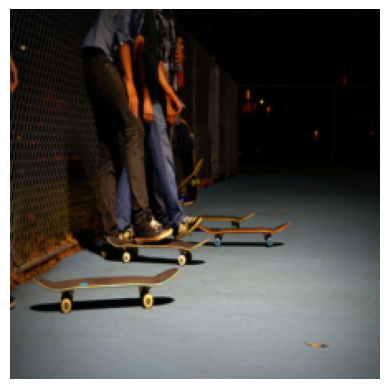

In [8]:
# Fetch one batch of images
for images, captions in data_loader:
    break

# If you want to display the size of this batch or perform any simple operation
print(f"Size of the batch (images): {images.size()}")
print(f"Number of captions in this batch: {len(captions[0])}")
imshow(images[0])

# Preprocess Captions

The 'preprocess_captions' function takes as argument the data loader, and while iterating through all the captions, prepends a start token 'startword' and appends an end token 'endword' to each caption. They are also changed to lowercase, and tokenized using .split(). 

A vocabulary is constructed from the captions, consisting of every word that occurs once or more (basically, all of them!)

In [9]:
nltk.download('punkt')

def preprocess_captions(data_loader):
    captions = []
    for _, caps in data_loader:
        for cap in caps[0]:
            updated_cap = 'startword ' + cap.lower() + ' endword'

            # Tokenize the updated caption
            tokens = updated_cap.split()
            captions.append(tokens)

    word_count = Counter()
    # Build a vocabulary
    for cap in captions:
        word_count.update(cap)

    min_word_freq = 1

    vocab = [word for word in word_count if word_count[word] >= min_word_freq]

    # Create a tokenizer and fit it on the updated captions
    tokenizer = Tokenizer(num_words=len(vocab))
    tokenizer.fit_on_texts([" ".join(caption) for caption in captions])
    return tokenizer, word_count, vocab

tokenizer, word_count, vocab = preprocess_captions(data_loader)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghiar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The code below is used during inference, helping convert token indices back to words. 

In [10]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# Function to convert a list of indices to words
def indices_to_words(indices):
    return ' '.join([index_to_word.get(index, '') for index in indices])

# Evaluation Script

Below is a code block to be used for evaluation, that takes as input a list containing predicted captions, and a list containing true captions. 

The metric used is the BLEU score. It has been used in several literature, such as: 

1. Show and Tell: A Neural Image Caption Generator
2. Show, Attend and Tell: Neural Image Caption Generation with Visual Attention
3. Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering

The BLEU (Bilingual Evaluation Understudy) Score is a widely used metric for evaluating the quality of machine-translated text against high-quality human translations. Its extensive use in research is attributed to its ability to provide a standardized, objective, and quantitative measure of translation quality. BLEU score efficiently correlates with human judgment, particularly at the corpus level, making it a valuable tool for assessing the overall translation quality.

In the realm of image captioning, BLEU is utilized to assess how closely a model's generated captions align with human-generated reference captions. This metric is crucial not only for verifying the factual correctness of the captions but also for ensuring linguistic similarity to human expression.

We have calculated 2 different kinds of BLEU score. Below stated are the advantages and disadvantages of each, along with why they have been used: 

When comparing individual caption scoring (sentence-level BLEU) and overall corpus scoring (corpus-level BLEU), there are notable differences. Sentence-level BLEU evaluates each generated caption against its reference, averaging these scores for a final result. This method, while insightful for individual translations, can be sensitive to caption length and may not consistently align with human judgment. On the other hand, corpus-level BLEU calculates the score over the entire dataset. This approach considers all n-grams in the generated corpus, providing a more comprehensive assessment of the model's performance. Corpus-level BLEU is typically more stable and accurately reflects the system's effectiveness, making it the preferred method for evaluating and comparing the performance of translation or captioning systems.

FInally, a smoothing function has been used to ensure that if any n-gram is not present at all, the entire BLEU score does not drop to 0 (as it is computed using a geometric series of all the n-grams from 1 to 4). 

In [11]:
def evaluate(predictions, true_labels):
    chencherry = SmoothingFunction()

    scores = []
        
    for i in range(len(predictions)):
        truth = [true_labels[i].split()]
        pred = predictions[i].split()
        score = sentence_bleu(truth, pred, smoothing_function=chencherry.method3)

        scores.append(score)
    
    # Tokenize the sentences
    tokenized_pred = [pred.split() for pred in predictions]
    tokenized_true = [[label.split()] for label in true_labels]  # Note the double list for references

    # Calculate corpus-level BLEU score
    score = corpus_bleu(tokenized_true, tokenized_pred)

    print("Maximum BLEU Score (1-1) = ", max(scores))
    print("Average BLEU Score (1-1) = ", sum(scores)/len(scores))
    print("Corpus BLEU score = ", score)

# Simple Baseline

The simple baseline code is below. The total number of words, and count of each words have been stored, allowing for the creation of a probability distribution. Using the 'pick_word' function, the model picks one word from the vocabulary by "rolling a dice" and through the probability distribution. Thus, words that were more common in the corpus have a higher likelihood of appearing. 

The 'simple' function effectively runs the 'pick_word' function 10 times over to generate a caption for each image. 

In [12]:
total_words = sum(word_count.values())
probabilities = [count / total_words for count in word_count.values()]

def pick_word():
    return np.random.choice(vocab, p=probabilities)

def simple():
    sentence = []
    for i in range(10): 
        picked_word = pick_word()
        while picked_word == 'startword' or picked_word == 'endword': 
            picked_word = pick_word()
        sentence.append(str(picked_word))
    return ' '.join(sentence)

Evaluation on Test Set

True:  A red light is a wonderful contrast to the pink leaves on trees
Predicted:  large covered of a board. that a two about on


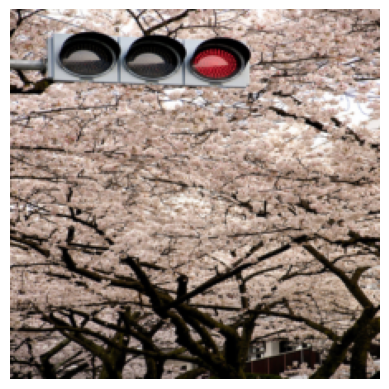

True:  A clean kitchen with the windows white and open.
Predicted:  with standing group of a body st front his wrapped


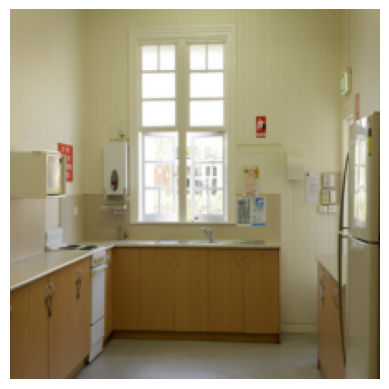

True:  A woman standing on top of a sandy beach with a surfboard.
Predicted:  a phone. the giraffe of combining tennis on waiting plate


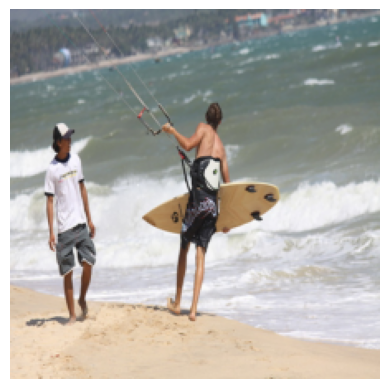

True:  a man is working on a hub cap on the ground
Predicted:  surfers with covered sitting around food of a walking bed


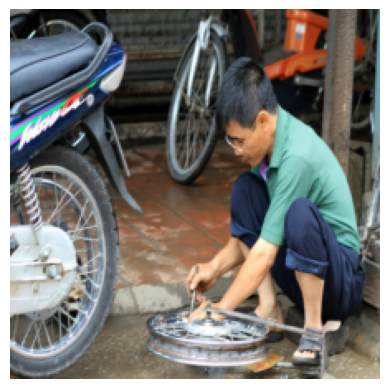

True:  Man with a hot dog in a paper rapper in his hand.
Predicted:  transfer a the an a dried day there in to


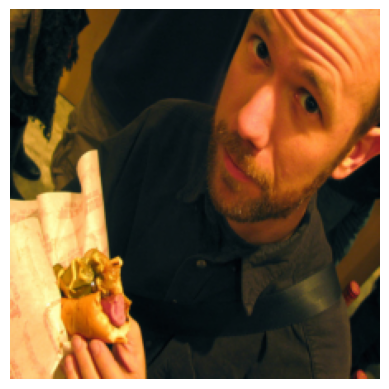

True:  A city passenger bus stopping to take on passengers.
Predicted:  snowboard a bench a medical tricks. jumping group a line


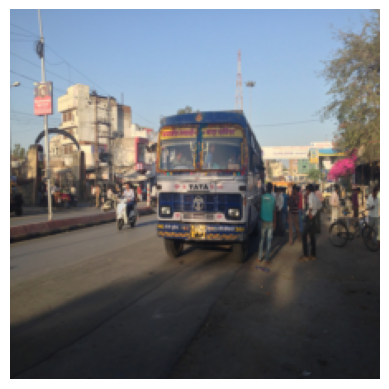

True:  a vety cute furry dog posing near a big sign.
Predicted:  a that a bunch black cement couple bears with picked


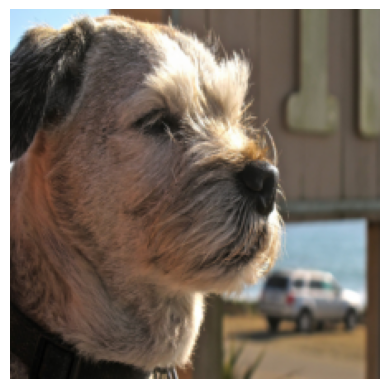

True:  A yellow and blue plant flying in a gray sky.
Predicted:  laptop dog licked continues with engine suitcase a on a


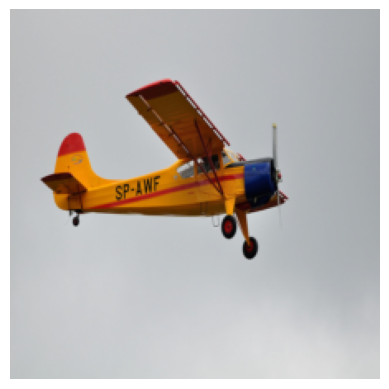

True:  A passenger bus that is parked in a parking lot.
Predicted:  hit next standing living on cabinets a several trees. holding


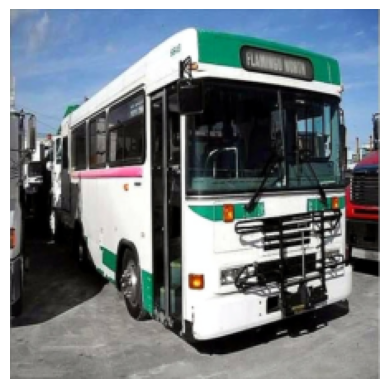

True:  The Big Ben clock tower towering over the city of London.
Predicted:  concrete nicely model black window dinosaur. and two grass. city


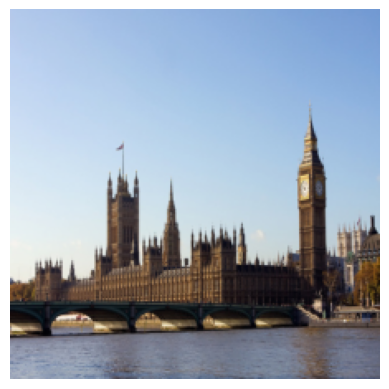

In [13]:
predictions = []
true_labels = []

for batch_id, (images, captions) in enumerate(val_loader):

        for i, image in enumerate(images):
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]

                truth = captions[0][i]
                pred = simple()

                # Print the true and predicted captions along with the image
                if batch_id == 0 and i < 10: 
                        print("True: ", truth)
                        print("Predicted: ", pred)
                        imshow(image)

                predictions.append(pred)
                true_labels.append(truth)


Results obtained with the following hyperparemeters:

trainSize = 4096, 
valSize = 256, 
batchSize = 32, 
num_epochs = 10

Test Scores: 

Maximum BLEU Score (1-1) =  0.092875289995668

Average BLEU Score (1-1) =  0.03337219703370978

Corpus BLEU score =  2.1224180565294363e-155

Train Scores: 

Maximum BLEU Score (1-1) =  0.1561969968460128

Average BLEU Score (1-1) =  0.035285571963484925

Corpus BLEU score =  1.886231695807803e-79

In [14]:
evaluate(predictions, true_labels)

Maximum BLEU Score (1-1) =  0.10112616398790837
Average BLEU Score (1-1) =  0.03578074394155406
Corpus BLEU score =  2.066714467188426e-155


C:\Users\ghiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ghiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Strong Baseline
The strong baseline contains a CNN in order to perform image feature extraction. The model used is a pretrained ResNet50. The final fully connected layer has been removed, which means there is no classification or regression needed, but only a feature representation of the image that can be provided as input to the LSTM. 

This LSTM takes the image features and tokenized captions and input and trains on them. Once train is complete, inference can take place. 

# CNN

In [15]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        # Use a pre-trained model (like ResNet50) and remove the final fully connected layer
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last fully connected layer

    def forward(self, x):
        # Forward pass, x should be a batch of images
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        return x

# Instantiate the model
CNN = FeatureExtractorCNN()
CNN = CNN.to(device)

C:\Users\ghiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ghiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Image Feature Extraction

A feature mapping dictionary is created that maps each caption to its respective feature mapping, that shall be used during training.  

In [16]:
# Extract features
CNN.eval()  # Set the CNN to evaluation mode

feature_mapping = {}

with torch.no_grad():  # Disable gradient computation
    for images, cap in data_loader:
        images = images.to(device)
        features = CNN(images)  # Extract features
        features.cpu().numpy()
        for i in range(len(cap[0])): 
            feature_mapping[cap[0][i]] = features[i]

In [17]:
# Extract features
CNN.eval()  # Set the CNN to evaluation mode

feature_mapping_val = {}

with torch.no_grad():  # Disable gradient computation
    for images, cap in val_loader:
        images = images.to(device)
        features = CNN(images)  # Extract features
        features.cpu().numpy()
        for i in range(len(cap[0])): 
            feature_mapping_val[cap[0][i]] = features[i]

# LSTM

This is a unidirectional LSTM that shall be used to predict the captions based on the provided image feature representation.

In [18]:
class LSTM(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM hidden state
        self.init_c = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM cell state
        self.word_embeddings = nn.Embedding(vocab_size,embed_dim)

    def forward(self, features, captions):
        # Initialize hidden and cell states with image features
        h = self.init_h(features).unsqueeze(0)
        c = self.init_c(features).unsqueeze(0)

        # Embed the captions
        embeddings = self.embed(captions)

        # Pass the embedded captions and states through the LSTM
        lstm_out, _ = self.lstm(embeddings, (h, c))

        # Output layer
        outputs = self.linear(lstm_out)

        return outputs
    
    def infer(self, features, max_len=10):
        features = features.to(device)

        # print("features size: ", features.size())
        batch_size = features.size(0)  # Get the current batch size
        h = self.init_h(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)
        c = self.init_c(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)

        # Initialize the input tensor for LSTM (assuming start with <start> token)
        start_token_index = tokenizer.word_index['startword']
        inputs = self.embed(torch.LongTensor([start_token_index]).to(device)).repeat(batch_size, 1).unsqueeze(1)

        predictions = [[start_token_index] for _ in range(batch_size)]

        for i in range(max_len):
            lstm_out, (h, c) = self.lstm(inputs, (h, c))

            outputs = self.linear(lstm_out.squeeze(1))
            _, predicted = outputs.max(1)

            # Iterate over each prediction in the batch
            for idx in range(batch_size):
                # Append each prediction separately
                predictions[idx].append(predicted[idx].item())
            inputs = self.embed(predicted).unsqueeze(1)

        return predictions


# Create the model
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 256
hidden_dim = 512
feature_dim = 2048  # Depending on your feature extractor output
CGLSTM = LSTM(feature_dim, embed_dim, hidden_dim, vocab_size)
CGLSTM = CGLSTM.to(device)

# Training

The training loop is shown below. Cross Entropy Loss has been used, and the loss calculation is defined by comparing the latest generated word to the word that would otherwise be in the ground truth caption. 

In [19]:
CGLSTM = CGLSTM.to(device)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CGLSTM.parameters(), lr=0.001)

# Training loop
if __name__ == '__main__':
    for epoch in range(num_epochs):
        for batch_id, (images, captions) in enumerate(data_loader):

            feature_list = []

            for i in range(batchSize): 
                temp = feature_mapping.get(captions[0][i])
                feature_list.append(feature_mapping.get(captions[0][i]))

            stacked_features = torch.stack(feature_list, dim=0)

            # Convert captions to sequences of integers
            sequences = tokenizer.texts_to_sequences(captions[0])
            sequences = pad_sequences(sequences, padding='post')

            # Convert to PyTorch tensors
            features = torch.tensor(stacked_features, dtype=torch.float32)
            features = features.to(device)
            captions = torch.tensor(sequences, dtype=torch.long)
            captions = captions.to(device)

            # Forward pass
            outputs = CGLSTM(features, captions[:, :-1])  # Exclude the last token

            # Calculate the loss
            outputs_reshaped = outputs.view(-1, vocab_size)
            targets = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs_reshaped, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

C:\Users\ghiar\AppData\Local\Temp\ipykernel_17220\1207459256.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(stacked_features, dtype=torch.float32)


Epoch [1/10], Loss: 3.0863
Epoch [2/10], Loss: 3.0749
Epoch [3/10], Loss: 1.7525
Epoch [4/10], Loss: 2.3110
Epoch [5/10], Loss: 2.6820
Epoch [6/10], Loss: 1.4555
Epoch [7/10], Loss: 1.5098
Epoch [8/10], Loss: 1.3905
Epoch [9/10], Loss: 1.2093
Epoch [10/10], Loss: 0.9615


# Inference

Inference is performed by the LSTM generating a caption taking into account the start word as the first word, followed by generating each new word with the previous hidden state as the input. In this manner, an entire caption is generated, limited to 10 words. 

True:  An orange cat sitting on top of a computer desk.
Predicted:  cat sleeping on top of a computer keyboard  


C:\Users\ghiar\AppData\Local\Temp\ipykernel_17220\2170054157.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(stacked_features, dtype=torch.float32)


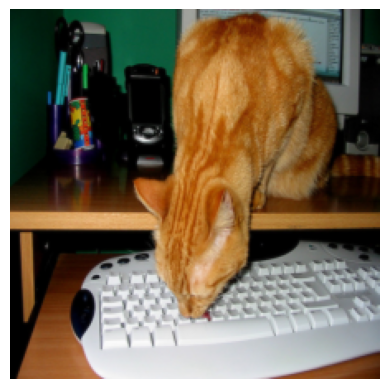

True:  A crowded airport filled with people carrying luggage.
Predicted:  is a man with a bike in front of a


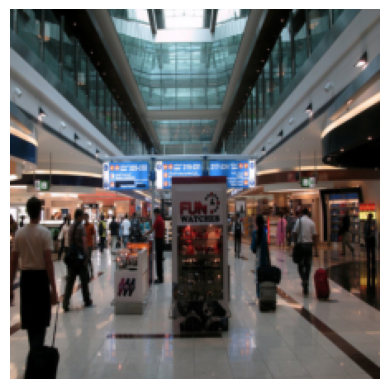

True:  A living room with a loveseat and chairs surrounding a table.
Predicted:  bed has a nightstand and a lamp in it 


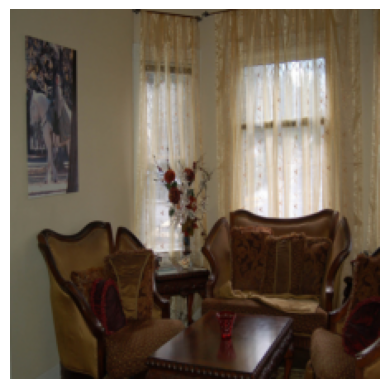

True:  This is a picture of a kitchen in a poverty area of a town.
Predicted:  old antique narrow of luggage in a room  


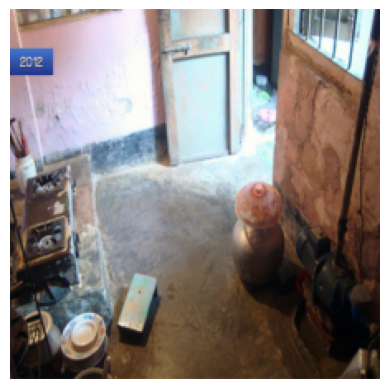

True:  a man and woman standing side by side in a kitchen next to a window
Predicted:  is a bathroom with a sink in a mirror 


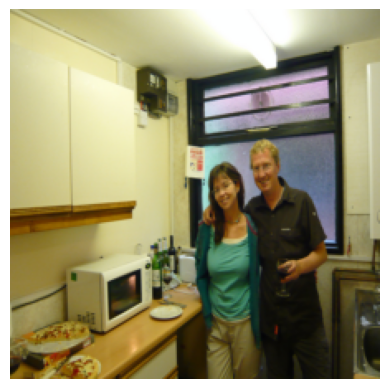

True:  A plate with a peanut butter sandwich, ham, and tomatoes. 
Predicted:  plate of food with a cheesy grilled grilled  


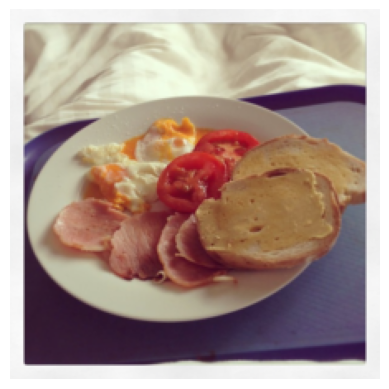

True:  A bluebery cake is on a plate and is topped with butter.
Predicted:  plate with a cheesy burger and a bowl of soup


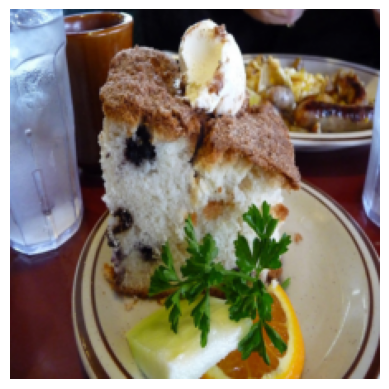

True:  The tower of the building has a clock displayed on it.
Predicted:  clock tower in the middle of a city street 


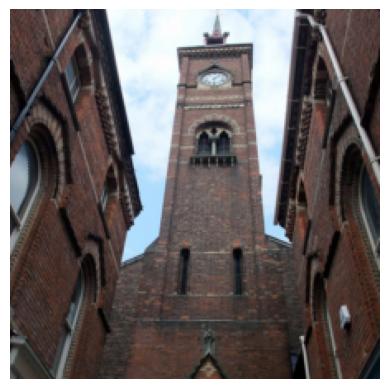

True:  A bowl filled with food on top of a wooden table.
Predicted:  is a plate of food on a table  


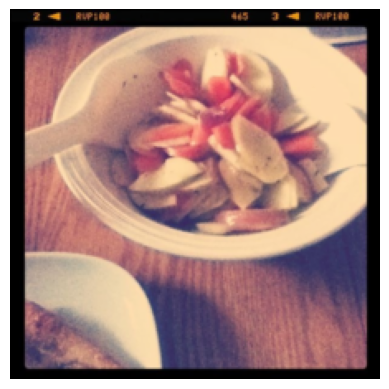

True:  Pictures of different types of prepared food containing beans.
Predicted:  is a bowl of broccoli on a plate  


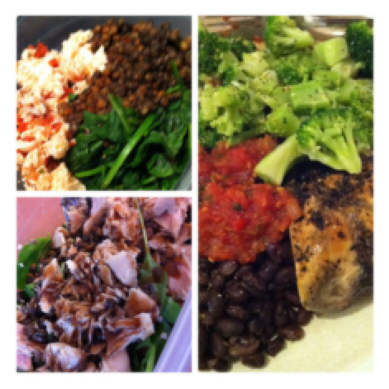

In [20]:
# Inference loop
CGLSTM.eval()

predictions = []
true_labels = []

for batch_id, (images, captions) in enumerate(val_loader):
        # Convert captions to sequences of integers
        feature_list = []

        for i in range(batchSize): 
                temp = feature_mapping.get(captions[0][i])
                feature_list.append(feature_mapping_val.get(captions[0][i]))

        stacked_features = torch.stack(feature_list, dim=0)

        # Convert to PyTorch tensors
        features = torch.tensor(stacked_features, dtype=torch.float32)
        features = features.to(device)

        caption_indices = CGLSTM.infer(features)
        
        for i, image in enumerate(images):
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]

                caption_words = indices_to_words(caption_indices[i])
                
                truth = captions[0][i]
                pred = caption_words[10:]

                predictions.append(pred)
                true_labels.append(truth)
		
	        # Print the true and predicted captions along with the image
                if batch_id == 0 and i < 10: 
                        print("True: ", truth)
                        print("Predicted: ", pred)
                        imshow(image)

Results obtained with the following hyperparemeters:

trainSize = 4096, 
valSize = 256, 
batchSize = 32, 
num_epochs = 10

Test Scores: 

Maximum BLEU Score (1-1) =  0.3655552228545123

Average BLEU Score (1-1) =  0.06452859599290038

Corpus BLEU score =  0.025611039085274106

Train Scores: 

Maximum BLEU Score (1-1) =  0.8824969025845955

Average BLEU Score (1-1) =  0.09843441902729833

Corpus BLEU score =  0.07431819096769145

In [21]:
evaluate(predictions, true_labels)

Maximum BLEU Score (1-1) =  0.7598356856515925
Average BLEU Score (1-1) =  0.07121025375610218
Corpus BLEU score =  0.03474617084527546
